In [2]:
import sklearn as sk
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def calculate_goal_dif(home_or_away, home_score, away_score):
    if home_or_away == 'HOME':
        return home_score - away_score
    else:
        return away_score - home_score
    

def normalize_data(df):
    norm_df = df.copy()
    for col in norm_df.columns:
        if norm_df.dtypes[col] == 'object':
            continue
        col_min = norm_df[col].min()
        col_max = norm_df[col].max()
        norm_df[col] = (norm_df[col] - col_min) / (col_max - col_min)
    return norm_df

In [4]:
file_path = '/Users/tylerviducic/dev/hockey_analytics/gamescore_model/data/cleaned_data/'
files = glob.glob(file_path + '*.csv')
df = pd.concat([pd.read_csv(f) for f in files], ignore_index = True)
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [5]:
df['game_goal_differential'] = df.apply(lambda row: calculate_goal_dif(row['home_or_away'], row['home_score'], row['away_score']), axis = 1)
df.describe()

,playerId,season,gameId,gameDate,icetime,shifts,gameScore,iceTimeRank,I_F_xOnGoal,I_F_xGoals,...,OnIce_A_scoreAdjustedUnblockedShotAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,home_score,away_score,game_goal_differential
count,6.357100e+05,635710.000000,6.357100e+05,6.357100e+05,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,...,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.00000,635710.000000,635710.000000,635710.000000,635710.000000
mean,8.473328e+06,2015.023764,2.015044e+09,2.015662e+07,990.174611,21.391614,0.450611,5.481737,1.680391,0.155841,...,9.092224,0.087494,0.093441,0.095902,0.511449,0.51314,0.505599,2.885135,2.619638,-0.001719
std,4.826895e+03,4.358557,4.358561e+06,4.398859e+04,292.598970,5.437033,0.734466,3.282639,1.393324,0.211990,...,4.232453,0.045160,0.176746,0.178932,0.289507,0.29158,0.285368,1.678371,1.583953,2.334779
min,8.445550e+06,2008.000000,2.008020e+09,2.008100e+07,1.000000,1.000000,-2.500000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-10.000000
25%,8.470612e+06,2011.000000,2.011021e+09,2.012012e+07,798.000000,18.000000,-0.060000,3.000000,0.692000,0.018000,...,6.042000,0.055000,0.000000,0.000000,0.298000,0.29800,0.295000,2.000000,1.000000,-2.000000
50%,8.474162e+06,2015.000000,2.015021e+09,2.016013e+07,998.000000,22.000000,0.300000,5.000000,1.434000,0.077000,...,8.698000,0.082000,0.000000,0.000000,0.472000,0.47300,0.467000,3.000000,2.000000,0.000000
75%,8.476854e+06,2019.000000,2.019020e+09,2.019102e+07,1189.000000,25.000000,0.850000,8.000000,2.390000,0.208000,...,11.684000,0.114000,0.141000,0.150000,0.680000,0.68200,0.672000,4.000000,4.000000,2.000000
max,8.484287e+06,2022.000000,2.022021e+09,2.023041e+07,2334.000000,46.000000,7.110000,13.000000,14.722000,3.598000,...,41.879000,0.446000,2.410000,2.410000,2.646000,2.74600,2.642000,10.000000,10.000000,10.000000


In [6]:
df.describe()
norm_df = normalize_data(df)
norm_df.describe()

,playerId,season,gameId,gameDate,icetime,shifts,gameScore,iceTimeRank,I_F_xOnGoal,I_F_xGoals,...,OnIce_A_scoreAdjustedUnblockedShotAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,home_score,away_score,game_goal_differential
count,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,...,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000,635710.000000
mean,0.717092,0.501697,0.501693,0.506100,0.423993,0.453147,0.307035,0.373478,0.114141,0.043313,...,0.217107,0.196176,0.038772,0.039793,0.193292,0.186868,0.191370,0.288513,0.261964,0.499914
std,0.124607,0.311326,0.311297,0.294415,0.125417,0.120823,0.076427,0.273553,0.094642,0.058919,...,0.101064,0.101255,0.073339,0.074246,0.109413,0.106183,0.108012,0.167837,0.158395,0.116739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.646978,0.214286,0.214318,0.261830,0.341620,0.377778,0.253902,0.166667,0.047004,0.005003,...,0.144273,0.123318,0.000000,0.000000,0.112623,0.108521,0.111658,0.200000,0.100000,0.400000
50%,0.738622,0.500000,0.500006,0.529570,0.427347,0.466667,0.291363,0.333333,0.097405,0.021401,...,0.207694,0.183857,0.000000,0.000000,0.178382,0.172251,0.176760,0.300000,0.200000,0.500000
75%,0.808116,0.785714,0.785652,0.736370,0.509216,0.533333,0.348595,0.583333,0.162342,0.057810,...,0.278994,0.255605,0.058506,0.062241,0.256992,0.248361,0.254353,0.400000,0.400000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
norm_df = norm_df.sample(frac = 1).reset_index(drop = True)

In [8]:
longest = 0
for column in norm_df.columns:
    if len(column) > longest:
        longest = len(column)

for i, column in enumerate(norm_df.columns):
    end = ' ' * (longest - len(column)) + ' | '
    if (i+1) % 2 == 0:
        end = '\n'
    print(column, end = end)

playerId                                                | season
name                                                    | gameId
playerTeam                                              | opposingTeam
home_or_away                                            | gameDate
position                                                | icetime
shifts                                                  | gameScore
iceTimeRank                                             | I_F_xOnGoal
I_F_xGoals                                              | I_F_xRebounds
I_F_xFreeze                                             | I_F_xPlayStopped
I_F_xPlayContinuedInZone                                | I_F_xPlayContinuedOutsideZone
I_F_flurryAdjustedxGoals                                | I_F_scoreVenueAdjustedxGoals
I_F_flurryScoreVenueAdjustedxGoals                      | I_F_primaryAssists
I_F_secondaryAssists                                    | I_F_shotsOnGoal
I_F_missedShots                                        

In [21]:
features = ['iceTimeRank', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_goals', 'I_F_hits', 'I_F_takeaways', 
            'I_F_dZoneGiveaways', 'shotsBlockedByPlayer','faceoffsWon', 'faceoffsLost', 'penalties', 
            'penaltiesDrawn', 'OnIce_F_xGoals', 'OnIce_F_goals', 'OnIce_A_xGoals', 'OnIce_A_goals']
target = ['game_goal_differential']
model_columns = features + target


In [10]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(norm_df[features], norm_df[target], test_size = 0.2)


In [11]:
from sklearn import linear_model

model = linear_model.LinearRegression()

In [12]:
model.fit(x_train, y_train)

LinearRegression()

In [13]:
[print(len(model.coef_[0]))]
print(f'coeficcients: ')
for feature, coef in zip(features, model.coef_[0]):
    print(f'{feature}: {coef}')

16
coeficcients: 
iceTimeRank: 0.02018316365566868
I_F_primaryAssists: 0.11284099379619615
I_F_secondaryAssists: 0.09292132496063708
I_F_goals: 0.11242152946879509
I_F_hits: -0.02530297851545533
I_F_takeaways: 0.02713546997074371
I_F_dZoneGiveaways: 0.022988999261252197
shotsBlockedByPlayer: 0.09101845362534611
faceoffsWon: 0.011782484765168525
faceoffsLost: -0.025250584232279657
penalties: -0.008855574301117513
penaltiesDrawn: -0.0007669904814444759
OnIce_F_xGoals: -0.03097592848126034
OnIce_F_goals: 0.2594103636892442
OnIce_A_xGoals: 0.021691868703402947
OnIce_A_goals: -0.29621225080403674


In [14]:
pred_y = model.predict(x_test)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'MSE: {mean_squared_error(y_test, pred_y)}')
print(f'R2: {r2_score(y_test, pred_y)}')

MSE: 0.010881558091078799
R2: 0.1945053685652196


In [16]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, 
    norm_df[features],
    norm_df[target],
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True
)

coefs = pd.DataFrame(
    [model_v.coef_[0] for model_v in cv_model['estimator']], columns=features
)

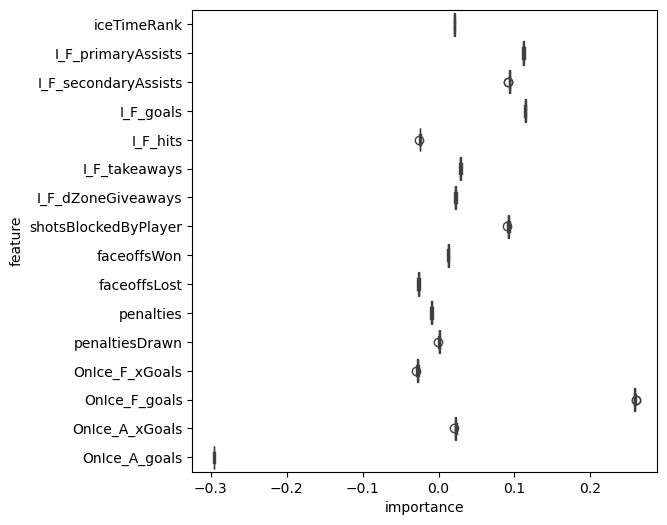

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=coefs, orient="h", ax=ax, color='cyan')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
plt.show()

In [22]:
# sns.pairplot(norm_df[model_columns], height = 7, aspect = 0.7, kind = 'reg', diag_kind=None)
# TODO: do this manually

KeyboardInterrupt: 